# SyncMap-core

> The core of SynCMap

In [ ]:
#| default_exp core

In [ ]:
#| export
import pandas as pd

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import normalized_mutual_info_score, pairwise_distances
from tqdm import tqdm
import copy
from collections import deque
from sklearn.manifold import TSNE

import sys
# sys.path.insert(0, '../')
# 如果没有 pip install -e . 下面一行就不会成功
from SyncMap_Draft.utility import OverlapChunkTest1, to_categorical, compute_combi_dist, reduce_dimension_with_tsne, create_trace_plot, labels2colors

from SyncMap_Draft.processor import GraphProcessor, WorkingMemProcessor, Readout
from scipy.stats import wasserstein_distance

from fastcore.utils import *

import time
import warnings

np.set_printoptions(suppress=True)  # disable scientific notation
# from plotly.subplots import make_subplots
# import plotly.graph_objs as go
# import fastcore.all as fc  # patch会报错
# from ipywidgets import widgets
# from IPython.display import display

## original syncmap

In [ ]:
#| export
class SyncMap:
	'''
	The original syncmap
	'''
	def __init__(self, input_size, dimensions, adaptation_rate):
		
		self.organized= False
		self.space_size= 10
		self.dimensions= dimensions
		self.input_size= input_size
		#syncmap= np.zeros((input_size,dimensions))
		np.random.seed(42)
		self.syncmap= np.random.rand(input_size,dimensions)
		self.adaptation_rate= adaptation_rate
		self.total_activation= np.zeros(input_size)
		#self.syncmap= np.random.rand(dimensions, input_size)
	
	def inputGeneral(self, x):
		plus= x > 0.1
		minus = ~ plus

		sequence_size = x.shape[0]
		#print(sequence_size, "asfasdfasdfasd")
		for i in range(sequence_size):
			
			vplus= plus[i,:]
			vminus= minus[i,:]
			plus_mass = vplus.sum()
			minus_mass = vminus.sum()
			self.total_activation+= vplus.astype(int)
			# self.total_activation-= vminus.astype(int)
			#print(plus_mass)
			#print(minus_mass)
			
			if plus_mass <= 1:
				continue
			
			if minus_mass <= 1:
				continue

			#print("vplus")
			#print(vplus)
			# np.dot(vplus,self.syncmap): syncmap的每个分量（1~8）在vplus中的贡献（投影）
			center_plus= np.dot(vplus,self.syncmap)/plus_mass
			center_minus= np.dot(vminus,self.syncmap)/minus_mass
		
			#print(self.syncmap.shape)
			#exit()
			dist_plus= distance.cdist(center_plus[None,:], self.syncmap, 'euclidean') # 质心到每个点的距离，相当于cluster的半径？
			dist_minus= distance.cdist(center_minus[None,:], self.syncmap, 'euclidean')
			dist_plus= np.transpose(dist_plus)
			dist_minus= np.transpose(dist_minus)
			
			update_plus= vplus[:,np.newaxis]*((center_plus - self.syncmap)/dist_plus)# + (self.syncmap - center_minus)/dist_minus)
			update_minus= vminus[:,np.newaxis]*((center_minus -self.syncmap)/dist_minus)
			
			update = update_plus - update_minus
			self.syncmap += self.adaptation_rate*update
			
			maximum=self.syncmap.max()
			self.syncmap= self.space_size*self.syncmap/maximum
			
		# self.total_activation= self.total_activation/sequence_size
		
		# self.syncmap = self.syncmap * self.total_activation[:, np.newaxis]


	def input(self, x):
		
		self.inputGeneral(x)

		return

			
	def organize(self):
	
		self.organized= True
		#self.labels= DBSCAN(eps=3, min_samples=2).fit_predict(self.syncmap)
		# self.labels= DBSCAN(eps=3, min_samples=2).fit_predict(self.syncmap)
		self.labels= DBSCAN(eps=0.8, min_samples=2).fit_predict(self.syncmap)

		return self.labels

	def activate(self, x):
		'''
		Return the label of the index with maximum input value
		'''

		if self.organized == False:
			print("Activating a non-organized SyncMap")
			return
		
		#maximum output
		max_index= np.argmax(x)

		return self.labels[max_index]

	def plotSequence(self, input_sequence, input_class,filename="plot.png"):

		input_sequence= input_sequence[1:500]
		input_class= input_class[1:500]

		a= np.asarray(input_class)
		t = [i for i,value in enumerate(a)]
		c= [self.activate(x) for x in input_sequence] 
		

		plt.plot(t, a, '-g')
		plt.plot(t, c, '-.k')
		#plt.ylim([-0.01,1.2])


		# plt.savefig(filename,quality=1, dpi=300)
		plt.show()
		plt.close()
	

	def plot(self, color=None, save = False, filename= "plot_map.png"):

		if color is None:
			color= self.labels
		
		print(self.syncmap)
		#print(self.syncmap)
		#print(self.syncmap[:,0])
		#print(self.syncmap[:,1])
		if self.dimensions == 2:
			#print(type(color))
			#print(color.shape)
			ax= plt.scatter(self.syncmap[:,0],self.syncmap[:,1], c=color)
			
		if self.dimensions == 3:
			fig = plt.figure()
			ax = plt.axes(projection='3d')

			ax.scatter3D(self.syncmap[:,0],self.syncmap[:,1], self.syncmap[:,2], c=color);
			#ax.plot3D(self.syncmap[:,0],self.syncmap[:,1], self.syncmap[:,2])
		
		if save == True:
			plt.savefig(filename)
		
		plt.show()
		plt.close()

### compute generative probability

In [ ]:
#| export
# extract data from parameter space

@patch
def generate_activity_probs(self:SyncMap, sample_x = 0, sample_y = 0, err = 1e-4):
    '''
    Generate the activity probabilities of each variable in syncmap
    return: np.array, shape = (self.output_size, )
    '''
    sample_cord = np.array([sample_x, sample_y])
    # probs = np.zeros(self.output_size)
    weight_dist = compute_combi_dist(self.syncmap)
    pos = np.where(weight_dist == weight_dist.max())[0]
    # tau = -weight_dist[*pos] / np.log(err)  # set tau to make the smallest prob to be err
    tau = -weight_dist.__getitem__(tuple(pos)) / np.log(err)
    # probs = np.exp(-weight_dist / tau)  
    sample_dist = ((self.syncmap - sample_cord) ** 2 ).sum(axis = -1)
    sample_probs = np.exp(-sample_dist / tau)
    return sample_probs

@patch
def plot_activity_maps(self:SyncMap, x = 0, y = 0):
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    sample_probs = self.generate_activity_probs(x, y)
    axs[0].scatter(self.syncmap[:, 0], self.syncmap[:, 1], color = 'blue')
    axs[0].scatter(x, y, color = 'red')
    axs[0].set_xlim(self.syncmap.min()-0.5, self.syncmap.max()+0.5)
    axs[0].set_ylim(self.syncmap.min()-0.5, self.syncmap.max()+0.5)
    sns.barplot(sample_probs, ax = axs[1])
    print(sample_probs)
    plt.show()

# SyncMap.generate_activity_probs = generate_activity_probs
# SyncMap.plot_activity_maps = plot_activity_maps

In [ ]:
# initialize the environment
time_delay = 10
env = OverlapChunkTest1(time_delay)
output_size = env.getOutputSize()
output_size

# sequence_length = 1000000
sequence_length = 10000

####### SyncMap #####
number_of_nodes= output_size
adaptation_rate= 0.001*output_size
print("Adaptation rate:", adaptation_rate)
map_dimensions= 2
neuron_group= SyncMap(number_of_nodes, map_dimensions, adaptation_rate)
input_sequence, input_class = env.getSequence(sequence_length)

Adaptation rate: 0.008


In [ ]:
neuron_group.input(input_sequence)
labels= neuron_group.organize()

print("Learned Labels: ",labels)
print("Correct Labels: ",env.trueLabel())

Learned Labels:  [ 0 -1  0  0  0  1  1 -1]
Correct Labels:  [0 0 0 1 1 2 2 2]


In [ ]:
neuron_group.syncmap

In [ ]:
np.random.seed(42)
SyncMap_weight = np.random.rand(output_size, map_dimensions)
plt.scatter(SyncMap_weight[:, 0], SyncMap_weight[:, 1])

In [ ]:
np.random.seed(42)
output_size = 8
map_dimensions = 2
SyncMap_weight = np.random.rand(output_size, map_dimensions)

# Create an array of colors, one for each point
# colors = np.random.rand(output_size)

plt.scatter(SyncMap_weight[:, 0], SyncMap_weight[:, 1], c=['red', 'red', 'red', 'blue', 'blue', 'black', 'black', 'black'])
# legend
plt.colorbar()
plt.show()

In [ ]:
np.random.seed(41)
output_size = 8
map_dimensions = 2
SyncMap_weight = np.random.rand(output_size, map_dimensions)

# Create an array of colors, one for each point
# colors = np.random.rand(output_size)

plt.scatter(SyncMap_weight[:, 0], SyncMap_weight[:, 1], c=['red', 'red', 'red', 'blue', 'blue', 'black', 'black', 'black'])
# legend
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(neuron_group.syncmap[:, 0], neuron_group.syncmap[:, 1], color = 'red')

In [ ]:
neuron_group.syncmap

In [ ]:
neuron_group.generate_activity_probs(sample_x = 0, sample_y = 0)

In [ ]:
neuron_group.plot_activity_maps(x = 1, y = -2.5)

In [ ]:
a = np.around(compute_combi_dist(neuron_group.syncmap), decimals = 4) 
a

In [ ]:
b = np.around(np.exp(-a), decimals = 4)
b

In [ ]:
pos = np.where(a == a.max())[0]
pos, a.__getitem__(tuple(pos)), a[pos]

### generate data from generative probability

In [ ]:
#| export
@patch
def extract_act_var(self:SyncMap, sample_x = 0, sample_y = 0, err = 1e-4):
    '''
    check if there is any activated variables
    '''
    probs = self.generate_activity_probs(sample_x, sample_y, err)  # Dim: d
    sampled_vars = np.random.binomial(1, probs)  # Dim: d
    # due to there is only 1 variables should be activated, we randomly choose one
    sampled_vars_idx = np.where(sampled_vars)[0]
    if len(sampled_vars_idx) == 0:
        return None 
    else:
        sampled_var = np.random.choice(sampled_vars_idx)
        return sampled_var


@patch
def create_element(self:SyncMap, sampled_var, env):
    '''
    create an element of the time series of the sampled variable
    '''
    tiny_series = np.zeros(env.output_size)
    if sampled_var is None:
        return tiny_series
    else:
        tiny_series[sampled_var] = 1
        return tiny_series


@patch
def create_series(self:SyncMap, x, y, env, seq_len = 1000):
    '''
    generate time series data
    '''
    time_series = []
    for _ in range(seq_len):
        sampled_var = self.extract_act_var(sample_x = x, sample_y = y)
        tiny_series = self.create_element(sampled_var, env)
        time_series.append(tiny_series)
    return np.array(time_series)

In [ ]:
(env.time_delay, env.output_size)

In [ ]:
neuron_group.extract_act_var(1, -2.5)

In [ ]:
neuron_group.create_series(x = 1, y = -2.5, env = env)

#### input data pattern

- chrunk 0: the variable `0, 1, 2, 3, 4` could be activated
- chrunk 1: the variable `3, 4, 5, 6 ,7` could be activated

In [ ]:
temp_sequence = input_sequence.copy()
temp_sequence[temp_sequence < 0.999] = 0
# temp_sequence[temp_sequence == 1] = 0

In [ ]:
env.plot_raw_data(input_sequence, input_class)

#### chunk 0

In [ ]:
env.plot_raw_data(temp_sequence[input_class==0, :], input_class[input_class==0])

#### chunk 1

In [ ]:
env.plot_raw_data(temp_sequence[input_class==1, :], input_class[input_class==1])

#### generated

In [ ]:
env.plot_raw_data(
    values = neuron_group.create_series(x = 1, y = -2.5, env = env, seq_len = 1000),
    labels = None
    )

## symmetrical syncmap

In [ ]:
#| export
class SymmetricalSyncMap:
    def __init__(self, input_size, dimensions=3, 
                adaptation_rate=0.1, space_scale=1.0, space_bound=None,
                leaking_rate=1.0, dropout_positive=0.0, dropout_negative=0.0,
                movmean_window=1000, movmean_interval=10,
                is_symmetrical_activation=False, number_of_selected_node=None,
                is_adaptive_LR=False, adaptive_LR_widrow_hoff=0.1):
        self.input_size = input_size
        self.dimensions = dimensions
        self.adaptation_rate = adaptation_rate
        self.space_scale = space_scale
        self.space_scale_dimensions_sqrt = space_scale * np.sqrt(dimensions)
        self.space_bound = space_bound
        self.leaking_rate = leaking_rate
        self.dropout_positive = dropout_positive
        self.dropout_negative = dropout_negative

        # initialize the sync map
        np.random.seed(42)
        self.syncmap = np.random.rand(self.input_size, self.dimensions) * self.space_scale
        self.syncmap = ((self.syncmap - np.mean(self.syncmap, axis=0)) / (np.std(self.syncmap, axis=0) + 1e-12)) * self.space_scale

        self.syncmap_movmean_list = deque(maxlen=movmean_window)
        self.syncmap_movmean = self.syncmap.copy()
        self.movmean_interval = movmean_interval

        # symmetrical activation
        self.is_symmetrical_activation = is_symmetrical_activation
        self.number_of_selected_node = number_of_selected_node

        # adaptive learning rate
        self.is_adaptive_LR = is_adaptive_LR
        self.adaptive_LR = 1
        self.adaptive_LR_widrow_hoff = adaptive_LR_widrow_hoff

        self.fit_log = []


    @property
    def log(self):
        return np.asarray(self.fit_log)

    def input_sequential(self, input_seq, current_state=None, Verbose_tqdm=True):
        # start processing
        if Verbose_tqdm:
            verbose = tqdm # use tqdm
        else:
            verbose = lambda x: x # do not use tqdm

        for i_state in verbose(range(len(input_seq))):
            state = input_seq[i_state]
            # current_state_idx = current_state[i_state] if current_state is not None else None
            self.adapt_chunking(input_state_vec=state)
            if i_state % self.movmean_interval == 0 or i_state == len(input_seq) - 1:
                self.syncmap_movmean_list.append(self.syncmap.copy())

        self.syncmap_movmean = np.mean(np.asarray(self.syncmap_movmean_list), axis=0)


    def adapt_chunking(self, input_state_vec):

        syncmap_previous = self.syncmap.copy()

        set_positive = input_state_vec == True
        set_negative = input_state_vec == False

        # symmetrical activation
        if self.is_symmetrical_activation:
            set_positive, set_negative = self.symmetrical_activation(set_positive.copy())

        if set_positive.sum() <= 1 or set_negative.sum() <= 1:
            return syncmap_previous

        centroid_positive = np.dot(set_positive, self.syncmap) / set_positive.sum()
        centroid_negative = np.dot(set_negative, self.syncmap) / set_negative.sum()

        dist_set2centroid_positive = distance.cdist(centroid_positive[None, :], self.syncmap, 'euclidean').T
        dist_set2centroid_negative = distance.cdist(centroid_negative[None, :], self.syncmap, 'euclidean').T

        # get dropout mask
        isDropout_positive = np.random.rand() > self.dropout_positive
        isDropout_negative = np.random.rand() > self.dropout_negative

        # update syncmap
        update_positive = set_positive[:, np.newaxis] * (centroid_positive - self.syncmap) / dist_set2centroid_positive
        update_negative = set_negative[:, np.newaxis] * (centroid_negative - self.syncmap) / dist_set2centroid_negative

        # adaptive learning rate regularization
        if self.is_adaptive_LR:
            adaptive_LR_positive, adaptive_LR_negative = self.update_adaptive_learning_rate(dist_set2centroid_positive, set_positive)
            update_positive = update_positive * adaptive_LR_positive
            update_negative = update_negative * adaptive_LR_negative

        self.syncmap += self.adaptation_rate * (update_positive * isDropout_positive - update_negative * isDropout_negative)

        # regularization
        # normalize the syncmap to have 0 mean and 1 std
        # self.syncmap = ((self.syncmap - np.mean(self.syncmap, axis=0)) / (np.std(self.syncmap, axis=0) + 1e-12)) * self.space_scale
        self.syncmap = (self.syncmap / self.syncmap.max()) * self.space_scale



        # leaking
        self.syncmap = self.leaking_rate * self.syncmap + (1 - self.leaking_rate) * syncmap_previous

        self.fit_log.append(self.syncmap.copy())
        return self.syncmap


    def get_syncmap(self, isMovMean=False):
        if isMovMean:
            self.syncmap_movmean = np.mean(np.asarray(self.syncmap_movmean_list), axis=0)
            return self.syncmap_movmean
        else:
            return self.syncmap

    def symmetrical_activation(self, input_vector):
        state_vector_plus = input_vector.copy()

        ## version 2 ##
        # Consider those positive nodes which are not selected in positive stochastic selection process
        number_of_selected_node_temp = state_vector_plus.sum()
        state_vector_plus = self.stochastic_selection(input_vector=state_vector_plus,
                                                    number_of_selected_node_overwrite=number_of_selected_node_temp)
        # update number_of_selected_node_temp
        number_of_selected_node_temp = state_vector_plus.sum()
        state_vector_minus = self.stochastic_selection(input_vector=~state_vector_plus,
                                                    number_of_selected_node_overwrite=number_of_selected_node_temp)


        return state_vector_plus, state_vector_minus

    def stochastic_selection(self, input_vector, number_of_selected_node_overwrite=None):
        number_of_activated_node = input_vector.sum()

        if self.number_of_selected_node is None:
            number_of_selected_node = number_of_selected_node_overwrite
        else:
            number_of_selected_node = self.number_of_selected_node



        if number_of_activated_node == 0:
            Pr = 0
        elif number_of_selected_node < number_of_activated_node: # randomly select a subset of nodes from the activated nodes
            Pr = number_of_selected_node / number_of_activated_node
        else: # select all the activated nodes
            Pr = 1

        state_vector_after_masking = np.logical_and(input_vector, np.random.rand(len(input_vector)) < Pr)
        return state_vector_after_masking

    def update_adaptive_learning_rate(self, dist_set2centroid_positive, set_positive):
        dist_avg_positive = np.sum(dist_set2centroid_positive * set_positive[:, None]) / set_positive.sum()
        adaptive_LR_positive = dist_avg_positive / self.space_scale_dimensions_sqrt

        ### version 4:
        self.adaptive_LR += self.adaptive_LR_widrow_hoff * (adaptive_LR_positive - self.adaptive_LR)
        adaptive_LR_positive = copy.deepcopy(self.adaptive_LR)
        adaptive_LR_negative = 1

        adaptive_LR_negative_amplifier_a = 0.01
        adaptive_LR_negative_amplifier_b = 2
        adaptive_LR_negative_amplifier = self.input_size * adaptive_LR_negative_amplifier_a + adaptive_LR_negative_amplifier_b
        adaptive_LR_negative_threshold = 1.5
        adaptive_LR_negative = self.adaptive_LR * adaptive_LR_negative_amplifier
        if adaptive_LR_negative > adaptive_LR_negative_threshold:
            adaptive_LR_negative = adaptive_LR_negative_threshold

        adaptive_LR_positive_threshold = 0.05
        if adaptive_LR_positive < adaptive_LR_positive_threshold:
            return adaptive_LR_positive_threshold, adaptive_LR_negative
        else:
            return adaptive_LR_positive, adaptive_LR_negative

    def set_adaptation_rate(self, adaptation_rate):
        self.adaptation_rate = adaptation_rate


For graph problem

In [ ]:
# temp_path = f'../data/probabilistic5_6.dot'
temp_path = f'../data/UB_prob_chunk_20_10_5.dot'

num_trails_per_problem = 1
state_memory = 2
number_of_selected_node = 2 # <=state_memory
max_seq_length = 300000

# start testing
nmi_total_list = []
eps_min_total_list = []
eps_max_total_list = []


# experiment start
file_path = temp_path
preprocessor = GraphProcessor()
preprocessor.read_graph_from_dot(file_path=file_path)
groundtruth_labels = preprocessor.get_groundtruth_labels()
connection_matrix = preprocessor.get_connection_matrix()
num_of_nodes = connection_matrix.shape[0]

nmi_trail_list = []
eps_min_trail_list = []
eps_max_trail_list = []
for i_trail in range(num_trails_per_problem):
    print(f"Trail {i_trail+1}/{num_trails_per_problem}")

    ###########################################################################################################
    # initialize sequence generator and set state_memory
    seq_generator = WorkingMemProcessor(state_memory=state_memory)

    # generate random walk on graph
    input_seq_trajectory, input_seq_onehot = preprocessor.random_walk_on_graph(L=max_seq_length, reset_time=None)

    # generate input sequence for syncmap
    input_seq = seq_generator.seq_gen_naive(input_seq=input_seq_onehot)

    # # initialize syncamap
    # model_syncmap = SymmetricalSyncMap(input_size=num_of_nodes, dimensions=15, adaptation_rate=0.01, space_scale=1,
    #                         leaking_rate=1.0, movmean_window=2000, movmean_interval=2,
    #                         is_symmetrical_activation=True, number_of_selected_node=2,)

    # uncomment below to use original syncmap
    model_syncmap = SymmetricalSyncMap(input_size=num_of_nodes, dimensions=15, adaptation_rate=0.01, space_scale=1)

    print("training SyncMap...")
    model_syncmap.input_sequential(input_seq)
    learned_map = model_syncmap.get_syncmap(isMovMean=True)

    # readout
    readout = Readout(learned_map, ground_truth=groundtruth_labels)
    # from a range if eps, find the eps that yields the best NMI
    eps_list = np.linspace(0.005, 5, 100)
    best_nmi = 0
    best_prediction_labels = None
    best_eps_min = eps_list[0]
    best_eps_max = eps_list[0]
    for eps in eps_list:
        readout.dbscan_(eps=eps, min_samples=2, print_result=False)
        nmi = readout.cal_NMI(print_result=False)
        # there might be multiple eps that have the same best nmi, we record the first one as the best_eps_min
        # and the last one as the best_eps_max
        if nmi > best_nmi:
            best_nmi = nmi
            best_prediction_labels = readout.predicted_labels
            best_eps_min = eps
        if nmi == best_nmi:
            best_eps_max = eps
            best_prediction_labels = readout.predicted_labels # overwrite the best_prediction_labels to prevent -1 in dbscan


    print("Groundtruth labels:", groundtruth_labels)
    print("Best prediction labels:", best_prediction_labels)
    print("Best eps:", best_eps_min, best_eps_max)
    print("Best NMI:", best_nmi)
    nmi_trail_list.append(best_nmi)
    eps_min_trail_list.append(best_eps_min)
    eps_max_trail_list.append(best_eps_max)

    # # visualize the syncmap in 3d
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # map_tsne = TSNE(n_components=3, perplexity=5).fit_transform(learned_map)
    # # ax.scatter(learned_map[:, 0], learned_map[:, 1], learned_map[:, 2], c=groundtruth_labels, marker='o', s=10)
    # ax.scatter(map_tsne[:, 0], map_tsne[:, 1], map_tsne[:, 2], c=groundtruth_labels, marker='o', s=100)
    # plt.show()

    # 2d tsne
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # map_tsne = TSNE(n_components=2, perplexity=5).fit_transform(learned_map)
    # ax.scatter(map_tsne[:, 0], map_tsne[:, 1], c=groundtruth_labels, marker='o')
    # plt.show()

    time.sleep(0.1)

    

nmi_avg = np.mean(nmi_trail_list)
nmi_std = np.std(nmi_trail_list)
eps_min_avg = np.mean(eps_min_trail_list)
eps_min_std = np.std(eps_min_trail_list)
eps_max_avg = np.mean(eps_max_trail_list)
eps_max_std = np.std(eps_max_trail_list)
print(temp_path.split('/')[-1].split('.')[0])
print(f"Average NMI: {nmi_avg}, std: {nmi_std}")
print(f"Average eps_min: {eps_min_avg}, std: {eps_min_std}")
print(f"Average eps_max: {eps_max_avg}, std: {eps_max_std}")
nmi_total_list.append(nmi_trail_list)
eps_min_total_list.append(eps_min_trail_list)
eps_max_total_list.append(eps_max_trail_list)

In [ ]:
# #| export
# def labels2colors(labels):
#     colorbar = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'pink', 'brown', 'gray']
#     return [colorbar[label] for label in labels]

In [ ]:
color_list = labels2colors(groundtruth_labels)
color_list

reduce dimensions

In [ ]:
reduced_fit_log = reduce_dimension_with_tsne(
    np.asarray(model_syncmap.fit_log)[::1000]
)

plot the syncmap variable space

In [ ]:
fig = create_trace_plot(reduced_fit_log, colors = color_list)
fig.show()


for overlapping problem

In [ ]:
time_delay = 10
env = OverlapChunkTest1(time_delay)
output_size = env.getOutputSize()
output_size

sequence_length = 10000
# sequence_length = int(1000000)  # TRUE TETST
 
####### SyncMap #####
number_of_nodes= output_size
adaptation_rate= 0.00005*output_size
print("Adaptation rate:", adaptation_rate)
map_dimensions= 2
model_syncmap= SymmetricalSyncMap(input_size=number_of_nodes, dimensions=map_dimensions, adaptation_rate=adaptation_rate, space_scale=1)
input_sequence, input_class = env.getSequence(sequence_length)

Adaptation rate: 0.0004


In [ ]:
model_syncmap.input_sequential(input_sequence>0.1)
learned_map = model_syncmap.get_syncmap(isMovMean=True)

100%|██████████| 1000000/1000000 [00:15<00:00, 65834.26it/s]


In [ ]:
# plt.scatter(learned_map[:, 0], learned_map[:, 1])

In [ ]:
# SymmSyncMapRst = {'data': model_syncmap.log, 'labels': env.trueLabel()}
# np.save('../data/SymmSyncMapRst.npy', SymmSyncMapRst)

In [ ]:
color_list = labels2colors(env.trueLabel())
color_list, model_syncmap.log.shape

fig = create_trace_plot(model_syncmap.log[::10000], colors = color_list)
fig.show()

## LightSyncMap

In [ ]:
#| export
class LightSyncMap:
	'''
	The original syncmap
	'''
	def __init__(self, input_size, dimensions, adaptation_rate):
		
		self.organized= False
		self.space_size= 10
		self.dimensions= dimensions
		self.input_size= input_size
		#syncmap= np.zeros((input_size,dimensions))
		np.random.seed(42)
		self.syncmap= np.random.rand(input_size,dimensions)
		self.adaptation_rate= adaptation_rate
		self.delay_effect = 0.8
		self.fit_log = []


	@property  # 在class内部引用这个函数贼慢
	def log(self):
		return np.asarray(self.fit_log)

	def fit(self, input_sequence):
		for idx, state in tqdm(enumerate(input_sequence), total=len(input_sequence)):
			vplus, vminus = self.get_postive_and_negative_state(state)
			if idx == 39:
				x0 = None
			new_snycmap = self.one_step_organize(vplus, vminus)

			if new_snycmap is not None:
				self.syncmap = new_snycmap[:]

	def get_postive_and_negative_state(self, state):
		'''
			adentify the state whether is activated and deactivated
		args:
			state(d): np.ndarray, the one step input sequence, d is the number of feature of input
		return:
			plus, minus(D): np.ndarray, th elements are boolean representing the activated and deactivated state
		'''
		plus= state > 0.1
		minus = ~ plus
		return plus, minus
		

	def get_center(self, arr, syncmap_arr):
		'''
		calculate the mass center of the input arrays.
		If the activated or deactivated state just one sample, return  None
		args:
			arr(d): np.array, features
		'''
		arr_mass = arr.sum()
		if arr_mass <= 1:
			return None
		# elif arr_mass == arr.shape[0]:
		# 	return None
		else:
			return (arr @ syncmap_arr) / arr_mass  # (D,) @ (D, d) -> (d,); D: features of input, d: features of syncmap


	def update(self, update_plus, update_minus, syncmap_arr):
		'''
		update the syncmap
		args:
			update_plus(d, D): np.ndarray, the update of activated state
			update_minus(d, D): np.ndarray, the update of deactivated state
		'''
		update = update_plus - update_minus
		syncmap_arr += self.adaptation_rate * update
		maximum = syncmap_arr.max()
		return syncmap_arr / maximum # self.space_size*


	def one_step_organize(self, vplus, vminus):
		syncmap_previous = self.syncmap.copy()
		center_plus  = self.get_center(vplus, syncmap_previous)
		center_minus = self.get_center(vminus, syncmap_previous)
		
		if center_plus is None or center_minus is None:
			return None

		dist_plus= distance.cdist(center_plus[None,:], syncmap_previous, 'euclidean').T
		dist_minus= distance.cdist(center_minus[None,:], syncmap_previous, 'euclidean').T

		update_plus= vplus[:,np.newaxis]*((center_plus - syncmap_previous)/dist_plus)
		update_minus= vminus[:,np.newaxis]*((center_minus - syncmap_previous)/dist_minus)  # the mod is 1

		# disable the update of too far nodes
		# update_plus[dist_plus.squeeze()>0.5] = 0
		# update_minus[dist_minus.squeeze()>0.5] = 0

		new_syncmap = self.update(update_plus, update_minus, syncmap_previous)
		
		self.fit_log.append(new_syncmap)
		return new_syncmap
			
	def cluster(self):
		self.organized= True
		# self.labels= DBSCAN(eps=3, min_samples=2).fit_predict(self.syncmap)
		self.labels= DBSCAN(eps=1, min_samples=2).fit_predict(self.syncmap)

		return self.labels

	def activate(self, x):
		'''
		Return the label of the index with maximum input value
		'''

		if self.organized == False:
			print("Activating a non-organized SyncMap")
			return
		
		#maximum output
		max_index= np.argmax(x)

		return self.labels[max_index]

In [ ]:
# initialize the environment
time_delay = 10
env = OverlapChunkTest1(time_delay)
output_size = env.getOutputSize()
output_size

sequence_length = 10000
# sequence_length = int(1000000)  #  True test

####### SyncMap #####
number_of_nodes= output_size
# adaptation_rate= 0.0005*output_size
adaptation_rate= 0.00005*output_size
print("Adaptation rate:", adaptation_rate)
map_dimensions= 2
neuron_group= LightSyncMap(number_of_nodes, map_dimensions, adaptation_rate)
input_sequence, input_class = env.getSequence(sequence_length)

Adaptation rate: 0.0004


In [ ]:
neuron_group.fit(input_sequence)
labels= neuron_group.cluster()

print("Learned Labels: ",labels)
print("Correct Labels: ",env.trueLabel())

100%|██████████| 1000000/1000000 [00:11<00:00, 85568.54it/s]

Learned Labels:  [0 0 0 0 0 1 1 1]
Correct Labels:  [0 0 0 1 1 2 2 2]


In [ ]:
neuron_group.syncmap

In [ ]:
# fig, ax = plt.subplots(figsize = (5, 5))
# sns.scatterplot(x = neuron_group.syncmap[:, 0], y = neuron_group.syncmap[:, 1], hue=env.trueLabel(), ax = ax)
# # set the x-axis range from -10 to 10
# # ax.set_xlim(-10, 10)
# # ax.set_ylim(-10, 10)

In [ ]:
color_list = labels2colors(env.trueLabel())
color_list, neuron_group.log.shape
fig = create_trace_plot(neuron_group.log[::10000], colors = color_list)
fig.show()

In [ ]:
# NormalSyncMap = {'data': neuron_group.log, 'labels': env.trueLabel()}
# np.save('../data/NormalSyncMap.npy', NormalSyncMap)

## NodeSyncMap

In [ ]:
def calculate_pairwise_distances(arr):
    """
    Calculate the pairwise distances between samples in a NumPy array.

    Parameters:
    arr (np.ndarray): A 2D NumPy array of shape (N, d) where N is the number of samples
                        and d is the dimension of each sample.

    Returns:
    np.ndarray: A 2D NumPy array of shape (N, N) where each element (i, j) represents
                the distance between sample i and sample j.
    """

    # Calculate the pairwise distances
    diff = arr[np.newaxis, :, :] - arr[:, np.newaxis, :] 
    squared_diff = diff ** 2
    squared_dist = np.sum(squared_diff, axis=-1)
    distances = np.sqrt(squared_dist)
    return distances

In [ ]:
a00 = np.array([[-1,0], [1,0], [0,2]])
a00_coord_diff = a00[np.newaxis, :, :] - a00[:, np.newaxis, :]
pair_dist = calculate_pairwise_distances(a00.reshape(3, 2))
a00_coord_diff

In [ ]:
with np.errstate(divide='ignore', invalid='ignore'):
    ttk = np.nan_to_num(a00_coord_diff / pair_dist[:, :, np.newaxis] ** 3, nan=0).sum(axis=0)

ttk

In [ ]:
# pair_dist[:, :, np.newaxis]
# a00_coord_diff
print(np.broadcast_to(a00[np.newaxis, :, :], (3, 3, 2)))
print('---')
print(np.broadcast_to(a00[:, np.newaxis, :], (3, 3, 2)))
# a00 = np.arange(12).reshape(3, 4)
# np.broadcast_to(a00[:, np.newaxis, :], (3, 3, 4)) == np.broadcast_to(a00[np.newaxis, :, :], (3, 3, 4)).transpose(1, 0, 2)


In [ ]:
class NodeSyncMap(LightSyncMap):
    def __init__(self, input_size, dimensions, adaptation_rate, ):
        super().__init__(input_size, dimensions, adaptation_rate)
        self.plus_factor = 1
        self.minus_factor = 0.1
        self.repel_range = 1
        self.plus_exp_factor = 0.2
        self.attract_range =  0.0001  # 0.5
        # self.trajectory_attract = 10
        
        self.last_activity = None
        self.last_activity_factor = 10
        self.history_repel = np.zeros((input_size, input_size))
        


    def calculate_pairwise_distances(self, arr):
        """
        Calculate the pairwise distances between samples in a NumPy array.

        Parameters:
        arr (np.ndarray): A 2D NumPy array of shape (N, d) where N is the number of samples
                            and d is the dimension of each sample.

        Returns:
        np.ndarray: A 2D NumPy array of shape (N, N) where each element (i, j) represents
                    the distance between sample i and sample j.
        """

        # Calculate the pairwise distances
        diff = arr[np.newaxis, :, :] - arr[:, np.newaxis, :] 
        squared_diff = diff ** 2
        squared_dist = np.sum(squared_diff, axis=-1)
        distances = np.sqrt(squared_dist)
        return distances


    def compute_wasserstein_distances(self, trajectories):
        # Get the shape of the input array
        T, N, D = trajectories.shape
        
        # Initialize the result array
        wasserstein_matrix = np.zeros((N, N))
        
        # Loop through each pair of variables
        for i in range(N):
            for j in range(i, N):  # Use symmetry to reduce computations
                # Extract the trajectories of the two variables
                traj_i = trajectories[:, i, :].reshape(T * D)
                traj_j = trajectories[:, j, :].reshape(T * D)
                
                # Compute the Wasserstein distance
                distance = wasserstein_distance(traj_i, traj_j)
                
                # Store the distance in the result array
                wasserstein_matrix[i, j] = distance
                wasserstein_matrix[j, i] = distance  # Symmetric matrix
        
        return wasserstein_matrix


    def exp_update(self, dist, affective_range):
        return np.exp(- dist / affective_range)

    def repel_constant_update(self, plus_mask, minus_mask):
        # 排斥重来没有连接过的
        '''
            return: (N, N, D)
        '''
        self.history_repel += minus_mask
        self.history_repel[plus_mask] = 0
        self.history_repel = np.minimum(self.history_repel, 1000)
        return self.history_repel[:,:,np.newaxis]/1000

    # def similar_trajectory_update(self, ):
    #     length_of_log = len(self.fit_log)
    #     if length_of_log < 10_000:
    #         return np.zeros((self.input_size, self.input_size)) < -1  # need false here
    #     elif length_of_log % 10_000 == 0:
    #         trajectory = np.asarray(self.fit_log[-10_000:])
    #         self.similar_attract_idx = self.compute_wasserstein_distances(trajectory)
    #         return self.similar_attract_idx<1
    #     else:
    #         return np.zeros((self.input_size, self.input_size)) < -1
        
    def compute_update(self, syncmap_previous, vplus, vminus):
        last_update_plus = None
        all2all_distance = self.calculate_pairwise_distances(syncmap_previous)  # (N, N)
        all_coordinate_diff = syncmap_previous[np.newaxis, :, :] - syncmap_previous[:, np.newaxis, :]  # 这个方向代表了排斥
        
        with np.errstate(divide='ignore', invalid='ignore'):
            all_coordinate_diff_sin_cos = np.nan_to_num(all_coordinate_diff / all2all_distance[:, :, np.newaxis] ** 1, nan=0)  # ** 2是为了引入距离关系， ** 1仅仅是方向向量 （N, N, D）
        # 在sum之前乘以系数可以为每个variable的排斥力加权； 



        # distance weighted plus update
        plus_mask  = (vplus[:, np.newaxis] @ vplus[np.newaxis, :])  # 防止正向对负向产生影响
        update_plus = -all_coordinate_diff_sin_cos.copy() * (
            1 + self.plus_exp_factor * self.exp_update(  # WARNING!
            all2all_distance.copy()[:, :, np.newaxis], self.attract_range))  # 由于`all_coordinate_diff`表明的原始方向是排斥的，所以这里是负号
        update_plus[~plus_mask] = 0
        update_plus = update_plus.sum(axis=0)



        # distance weighted minus update
        minus_mask = (vminus[:, np.newaxis] @ vminus[np.newaxis, :])  
        update_minus = all_coordinate_diff_sin_cos.copy() * (self.exp_update(
            all2all_distance.copy()[:, :, np.newaxis], self.repel_range) + self.repel_constant_update(plus_mask, minus_mask))
        update_minus[~minus_mask] = 0  # ~minus_mask: 所有含有正向的variables update全部置零
        update_minus = update_minus.sum(axis=0)


        # # last activity update
        # if (self.last_activity is not None) and np.all(self.last_activity != vplus):
        #     last_plus_mask = (self.last_activity[:, np.newaxis] @ self.last_activity[np.newaxis, :])
        #     last_update_plus = -all_coordinate_diff_sin_cos.copy() * (
        #         self.last_activity_factor  + self.plus_exp_factor * self.exp_update(
        #         all2all_distance.copy()[:, :, np.newaxis], self.attract_range))
        #     last_update_plus[~last_plus_mask] = 0
        #     last_update_plus = last_update_plus.sum(axis=0)

        #     update_plus += last_update_plus



        # update_minus = all_coordinate_diff_sin_cos.copy() * self.exp_update(
        #     all2all_distance.copy()[:, :, np.newaxis], self.repel_range) * (1+ self.repel_constant_update(plus_mask, minus_mask))

        # self.exp_update: distance weighted update
        # self.repel_constant_update: continuous repel update

        
        
        # TODO: 吸引累积叠加，如果负向连成一条线怎么避免五星连珠效应？


        # similar_value_mask = np.broadcast_to(self.similar_trajectory_update()[..., np.newaxis], (self.input_size, self.input_size, self.dimensions))  #

        # update_similar_plus = -all_coordinate_diff_sin_cos.copy() # * self.exp_update(all2all_distance.copy()[:, :, np.newaxis], self.attract_range)



        
        # update_similar_plus[~similar_value_mask] = 0


        # mask = np.broadcast_to((all2all_distance>0.5 & vminus[:, np.newaxis])[..., np.newaxis], (all2all_distance[0], all2all_distance[1], self.dimensions) ) # N, N, D
        # all_coordinate_diff_sin_cos[mask] = 0

        # all_coordinate_diff_sin_cos = all_coordinate_diff_sin_cos.sum(axis=0)
        
        
        # update_similar_plus = update_similar_plus.sum(axis=0)
        
        # update_plus += self.trajectory_attract * update_similar_plus
        return self.plus_factor * update_plus, self.minus_factor * update_minus



    def one_step_organize(self, vplus, vminus):
        syncmap_previous = self.syncmap.copy()
        syncmap_previous += np.random.normal(-1e-5, 1e-5, syncmap_previous.shape)
        center_plus  = self.get_center(vplus, syncmap_previous)
        center_minus = self.get_center(vminus, syncmap_previous)
        
        if center_plus is None or center_minus is None:
            return None


        # UPDATE BY USING ALL-TO-ALL
        update_plus, update_minus = self.compute_update(syncmap_previous, vplus, vminus)
        update_value = update_plus + update_minus  # 确实是加号
        new_syncmap = self.syncmap.copy()
        new_syncmap += self.adaptation_rate * update_value

        # new_syncmap = (new_syncmap - new_syncmap.mean()) / (new_syncmap.std() + 1e-12) 
        # new_syncmap = self.max_move_distance_test(syncmap_previous, new_syncmap, vplus, vminus, center_plus, center_minus, dist_plus, dist_minus)

        # new_syncmap = new_syncmap / np.abs(new_syncmap).max()

        self.fit_log.append(new_syncmap)
        return new_syncmap


In [ ]:
# initialize the environment
time_delay = 10
env = OverlapChunkTest1(time_delay)
output_size = env.getOutputSize()
output_size

# sequence_length = int(1000000) # True TEST
sequence_length = int(10000)  #  accuracy

####### SyncMap #####
number_of_nodes= output_size
adaptation_rate= 0.00005*output_size  # original
# adaptation_rate= 0.0005*output_size
print("Adaptation rate:", adaptation_rate)
map_dimensions= 2
neuron_group= NodeSyncMap(number_of_nodes, map_dimensions, adaptation_rate)
input_sequence, input_class = env.getSequence(sequence_length)

Adaptation rate: 0.0004


In [ ]:
# neuron_group.history_repel

In [ ]:
neuron_group.fit(input_sequence)
labels= neuron_group.cluster()

print("Learned Labels: ",labels)
print("Correct Labels: ",env.trueLabel())

100%|██████████| 1000000/1000000 [00:36<00:00, 27240.81it/s]

Learned Labels:  [0 0 0 1 1 2 2 2]
Correct Labels:  [0 0 0 1 1 2 2 2]


In [ ]:
color_list = labels2colors(env.trueLabel())
color_list, neuron_group.log.shape

fig = create_trace_plot(neuron_group.log[::10000], colors = color_list)
fig.show()

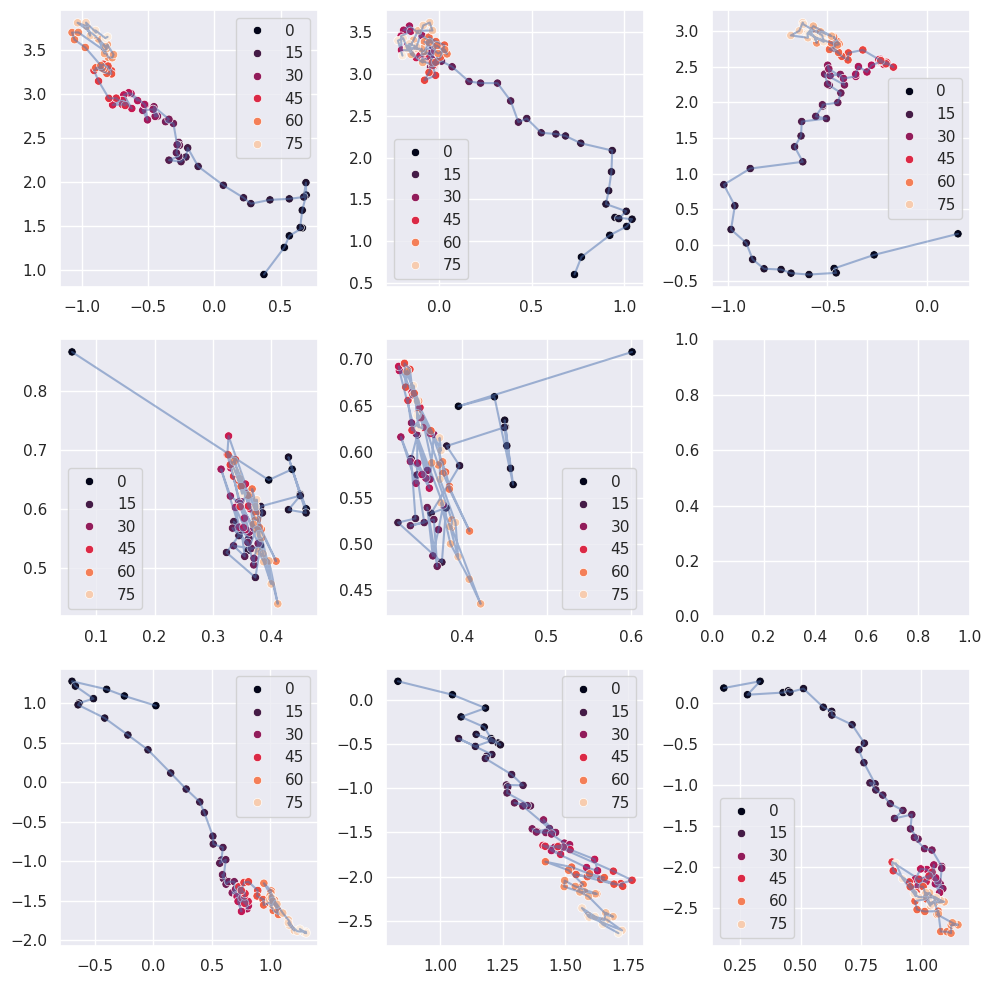

In [ ]:
# neuron_group.log[10000*12::10000]
# plt.plot(
#     neuron_group.log[10000*12::10000, 0], 
#     neuron_group.log[10000*12::10000, 1], marker='o')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('2D Trajectory of a Point')


# plt.figure(figsize=(8, 6))
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

for idx, item in enumerate(np.arange(8)):
        sns.scatterplot(
                x=neuron_group.log[10000*0::10000, item, 0], 
                y=neuron_group.log[10000*0::10000, item, 1], 
                hue=np.arange(len(neuron_group.log[10000*0::10000])), 
                palette="rocket", marker='o', ax = axs[idx if idx<5 else idx + 1])

        axs[idx if idx<5 else idx + 1].plot(neuron_group.log[10000*0::10000, item, 0], 
                neuron_group.log[10000*0::10000, item, 1], color='b', alpha=0.5)
fig.tight_layout()


In [ ]:
# NodeSyncMapRst = {'data': neuron_group.log, 'labels': env.trueLabel()}
# np.save('../data/NodeSyncMapRst.npy', NodeSyncMapRst)

In [ ]:
def compute_wasserstein_distances(trajectories):
    # Get the shape of the input array
    T, N, D = trajectories.shape
    
    # Initialize the result array
    wasserstein_matrix = np.zeros((N, N))
    
    # Loop through each pair of variables
    for i in range(N):
        for j in range(i, N):  # Use symmetry to reduce computations
            # Extract the trajectories of the two variables
            traj_i = trajectories[:, i, :].reshape(T * D)
            traj_j = trajectories[:, j, :].reshape(T * D)
            
            # Compute the Wasserstein distance
            distance = wasserstein_distance(traj_i, traj_j)
            
            # Store the distance in the result array
            wasserstein_matrix[i, j] = distance
            wasserstein_matrix[j, i] = distance  # Symmetric matrix
    
    return wasserstein_matrix

# # Example usage
# # T = 100, N = 5, D = 3
# trajectories = np.random.rand(100, 5, 3)
# result = compute_wasserstein_distances(trajectories)
# print(result)


<Axes: >

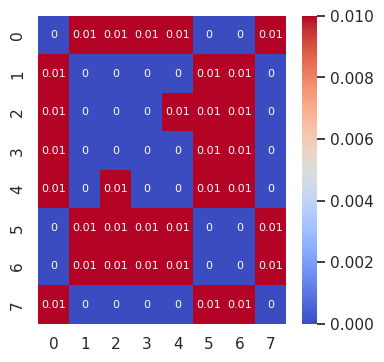

In [ ]:
# trajectory = neuron_group.log[10000*12::10000]
# trajectory = neuron_group.log[10000*2+3000:10000*2+4000:]
trajectory = np.random.rand(2000, 8, 2)
result = np.around(compute_wasserstein_distances(trajectory), 2)
# kl_matrix
# plot the matrix by using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(result, annot=True, cmap='coolwarm',  annot_kws={"size": 8})


## other

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()